In [1]:
import anndata
import os
import importlib
import pandas as pd
import numpy as np
import wandb
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [2]:
wandb.login(host="https://api.wandb.ai")

wandb: Currently logged in as: avantikalal (grelu). Use `wandb login --relogin` to force relogin


True

In [3]:
project_name="human-atac-catlas"

In [4]:
run = wandb.init(
    entity='grelu', project=project_name, job_type='training', name='train'
)

In [5]:
artifact = run.use_artifact('dataset:latest')
dir = artifact.download()

ad = anndata.read_h5ad(os.path.join(dir, "preprocessed.h5ad"))

wandb: Downloading large artifact dataset:latest, 202.72MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.5


## Split data

In [6]:
import grelu.data.preprocess
train_chroms='autosomes'
val_chroms=['chr7']
test_chroms=['chr13']
ad_train, ad_val, ad_test = grelu.data.preprocess.split(
    ad,
    train_chroms=train_chroms, val_chroms=val_chroms, test_chroms=test_chroms,
)

Selecting training samples
Keeping 1022128 intervals


Selecting validation samples
Keeping 63085 intervals


Selecting test samples
Keeping 36106 intervals
Final sizes: train: (204, 1022128), val: (204, 63085), test: (204, 36106)


## Make datasets

In [7]:
import grelu.data.dataset
train_dataset = grelu.data.dataset.AnnDataSeqDataset(
    ad_train.copy(),
    genome='hg38',
    rc=True, # reverse complement
    max_seq_shift=1, # Shift the sequence
    augment_mode="random", # Randomly select which augmentations to apply
)

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['chr18',
 'chr5',
 'chr1',
 'chr17',
 'chr9',
 'chr19',
 'chr8',
 'chr21',
 'chr14',
 'chr20',
 'chr22',
 'chr10',
 'chr15',
 'chr12',
 'chr16',
 'chr3',
 'chr4',
 'chr11',
 'chr2',
 'chr6']

In [8]:
val_dataset = grelu.data.dataset.AnnDataSeqDataset(
    ad_val.copy(), genome='hg38',
)

['chr7']

## Build model

In [18]:
model_params = {
    'model_type':'EnformerPretrainedModel', # Type of model
    'n_tasks': ad.shape[0], # Number of cell types to predict
    'crop_len':0, # No cropping of the model output
    'n_transformers': 1, # Number of transformer layers; the published Enformer model has 11
}

train_params = {
    'task':'binary', # binary classification
    'lr':1e-4, # learning rate
    'logger': 'wandb', # Logs will be written to wandb
    'batch_size': 1024,
    'num_workers': 16,
    'devices': 0, # GPU index
    'save_dir': project_name,
    'optimizer': 'adam',
    'max_epochs': 10,
    'checkpoint': True, # Save checkpoints
}

import grelu.lightning
importlib.reload(grelu.lightning)
model = grelu.lightning.LightningModel(
    model_params=model_params, train_params=train_params
)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.8


## Train model

In [ ]:
trainer = model.train_on_dataset(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:396: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Validation DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:06<00:00,  9.20it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.5036853551864624     │
│         val_auroc         │    0.49514129757881165    │
│        val_avgprec        │    0.10646370053291321    │
│        val_best_f1        │    0.17097324132919312    │
│         val_loss          │    0.6938810348510742     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]

  | Name         | Type                    | Params
---------------------------------------------------------
0 | model        | EnformerPretrainedModel | 72.1 M
1 | loss         | BCEWithLogitsLoss       | 0     
2 | val_metrics  | MetricCollection        | 0     
3 | test_metrics | MetricCollection        | 0     
4 | transform    | Identity                | 0     
---------------------------------------------------------
72.1 M    Trainable params
0         Non-trainable params
72.1 M    Total params
288.279   Total estimated model params size (MB)


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████| 999/999 [03:33<00:00,  4.67it/s, v_num=d9fu, train_loss_step=0.185]
Validation: |                                                                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|███████████████████████████████████████████████████████████████| 999/999 [03:36<00:00,  4.61it/s, v_num=d9fu, train_loss_step=0.165, train_loss_epoch=0.171]
Validation: |                                                                                                                                       | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|███████████████████████████████████████████████████████████████| 999/999 [03:34<00:00,  4.65it/s, v_num=d9fu, train_loss_step=0.132, train_loss_epoch=0.152]
Validation: |                                                                                                                                    

## Load best checkpoint

In [27]:
best_checkpoint = trainer.checkpoint_callback.best_model_path
print(best_checkpoint)
model = grelu.lightning.LightningModel.load_from_checkpoint(best_checkpoint)

human-atac-catlas/lightning_logs/a9p1d9fu/checkpoints/epoch=9-step=9990.ckpt


wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.7


## Evaluate model

In [28]:
test_dataset = grelu.data.dataset.AnnDataSeqDataset(
    ad_test.copy(), genome='hg38',
)

test_metrics = model.test_on_dataset(
    test_dataset,
    devices=0,
    num_workers=16,
    batch_size=1024,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:03<00:00,  9.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9575665593147278     │
│        test_auroc         │    0.8966840505599976     │
│       test_avgprec        │    0.5309234261512756     │
│       test_best_f1        │    0.5148430466651917     │
│         test_loss         │    0.13042709231376648    │
└───────────────────────────┴───────────────────────────┘

/usr/local/lib/python3.11/dist-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 17'. Pick better value with 'binwidth'.


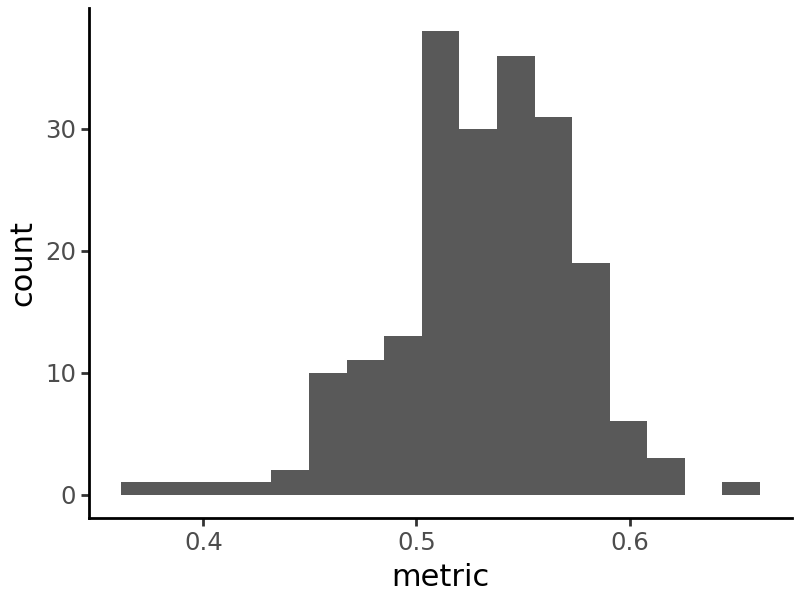

In [29]:
import grelu.visualize
grelu.visualize.plot_distribution(test_metrics.test_avgprec, method="histogram")

In [30]:
probs = model.predict_on_dataset(
    test_dataset,
    devices=0,
    num_workers=16,
    batch_size=1024,
    return_df=True # Return the output as a pandas dataframe
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [4]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:02<00:00, 14.16it/s]


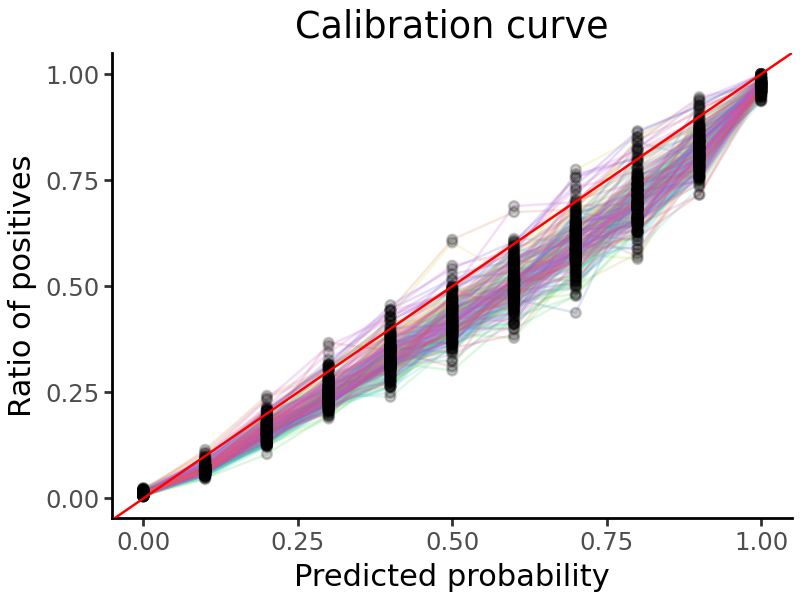

In [31]:
import grelu.visualize
grelu.visualize.plot_calibration_curve(
    probs, labels=test_dataset.labels, aggregate=False, show_legend=False
)

## Save

In [34]:
artifact = wandb.Artifact('model', type='model')

In [35]:
artifact.add_file(best_checkpoint, name="model.ckpt")
run.log_artifact(artifact)

<Artifact model>

In [36]:
run.finish()

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_loss_epoch,█▄▃▃▂▂▂▁▁▁
train_loss_step,█▆▆▂▄▅▂▄▄▃▃▃▄▄▂▄▃▃▃▂▃▄▄▄▂▃▁▄▄▃▁▃▁▂▃▄▂▃▂▃
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_accuracy,▁▁▁▅▆▇▇▇█████
val_auroc,▁▁▁▅▆▇▇▇█████
val_avgprec,▁▁▁▄▆▆▇▇▇████
val_best_f1,▁▁▁▄▆▆▇▇▇████
val_loss,███▄▃▂▂▂▁▁▁▁▁
epoch,9
train_loss_epoch,0.1409
